In [28]:
%load_ext autoreload

import sys
sys.path.append("../utils/")

# general imports
import matplotlib.pyplot as plt
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import numpy as np

import functools
import time

from quil_utils import *
from pyquil.quil import Pragma, Program
from pyquil.api import get_qc,QVM
from pyquil.gates import *
from quil_utils import Compiled_Circuit
from utils import DeviceUtils,DeviceScanner,BraketTaskScanner,Plotter,Gate_number
from IonQCompiler import IonQCompiler

from Noise_siumulator_Aspen_M2 import simulate_noise_aspen_m_2

import json

from hadamard_bench import*

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
@circuit.subroutine(register=True)
def GHZ (n_qubits):
    """
    Creates a GHZ circuit with n_qubits
    
    Parameters:
    ----------------
    n_qubits : int #of qubits
    """
    out = Circuit().h([0])
    for i in range(n_qubits-1):
        out.cnot(0,i+1)

    return out
        

In [3]:
rigetti = DeviceUtils.get_device('rigetti')
ion_q = DeviceUtils.get_device('ionq')
rigetti.is_available
#rigetti = LocalSimulator()
# ion_q = LocalSimulator()

False

In [14]:
shots = 1000
#set_n_qubits = range(3,10)
n_qubits_list = [2,4,6,8,10]

print(n_qubits_list)

[2, 4, 6, 8, 10]


In [14]:
id_dict = {}
rigetti_tasks = []
for n_qubits in n_qubits_list:
    id_dict[str(n_qubits)] = {}
    
    circ = GHZ (n_qubits)
    #print(circ)
    rigetti_task = rigetti.run(circ,shots=shots)
    rigetti_tasks.append(rigetti_task)
    
    id_dict[str(n_qubits)] = {'rigetti' : {'id' : rigetti_task.id,'BenchType':'GHZ','n_shots':shots,'n_qubits':n_qubits}}

In [15]:
with open('GHZ_rigetti.json','w') as f:
    json.dump(id_dict,f,indent=3)

In [16]:
rigetti_ids = [task.id for task in rigetti_tasks]

In [17]:
rigetti_task_scanners = [BraketTaskScanner(qtask=task) for task in rigetti_tasks]

In [9]:
def load_ids (filename):
    with open(filename,'r') as f:
        task_dict = json.load(f)
        rigetti_ids = []
        for key in task_dict:
            #print(task_dict[key])
            task = task_dict[key]
            rigetti_ids.append(task['rigetti']['id'])
    return rigetti_ids


In [10]:
rigetti_ids=load_ids('GHZ_rigetti.json')
rigetti_task_scanners = [BraketTaskScanner(task_arn=arn) for arn in rigetti_ids]

In [11]:
status_rigetti = [task.get_status() for task in rigetti_task_scanners]
print(status_rigetti)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [12]:
results_rigetti = [qtask.get_results() for qtask in rigetti_task_scanners]

In [15]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

for i,qubit_number in enumerate(n_qubits_list):
    results = results_rigetti[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]

measure_rigetti = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_rigetti

{'qubit_n': [2, 4, 6, 8, 10],
 'all_zeros': array([0.414, 0.255, 0.162, 0.012, 0.003]),
 'all_ones': array([0.436, 0.086, 0.025, 0.017, 0.   ]),
 'other': array([0.15 , 0.659, 0.813, 0.971, 0.997])}

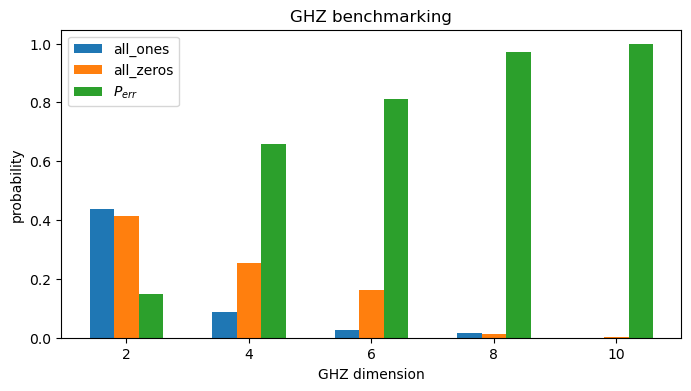

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_rigetti['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_rigetti['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_rigetti['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('GHZ benchmarking')
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

# IonQ compensated
Le simulazioni di Ionq sono anch'esse basate su GHZ ma aggiungendo randomicamente delle porte a singolo/due gates per mettere in luce che il suo vantaggio su Rigetti non dipende solamente da una minor overhead di compilazione

In [29]:
ion_q_compiler = IonQCompiler()

In [30]:
compiled_circuits_ion_q = [ion_q_compiler.compile(GHZ(n_qubits)) for n_qubits in n_qubits_list]
N_gates_ion_q = [len(ion_q_compiler.compile(GHZ(n_qubits)).instructions) for n_qubits in n_qubits_list]

In [31]:
compiled_circuits_rigetti = [task.get_compiled_circuit() for task in rigetti_task_scanners]

braket_circs_rigetti = [transpile_quil_to_braket(quil_circ)[0] for quil_circ in compiled_circuits_rigetti]
braket_circs_ion_q = compiled_circuits_ion_q

rigetti_gate_number_class = [Gate_number(circ) for circ in braket_circs_rigetti]
ionq_gate_number_class = [Gate_number(circ) for circ in braket_circs_ion_q]

In [33]:
def compensated_ghz_ion_q(n_qubits,rigetti_qubit_number_class):
    ion_q_compiler = IonQCompiler()
    GHZ_standard = GHZ (n_qubits)
    GHZ_std_compiled = ion_q_compiler.compile(GHZ_standard)
    rigetti_entangling_gates = rigetti_qubit_number_class.entangling_gates
    rigetti_one_qubit_gates = rigetti_qubit_number_class.one_qubit
    ion_q_entangling_gates = Gate_number(GHZ_std_compiled).entangling_gates
    ion_q_one_qubit_gates = Gate_number(GHZ_std_compiled).one_qubit
    
    
    GHZ_compensated = GHZ_std_compiled
    n_entangled_to_compensate = int(np.ceil(.5*(rigetti_entangling_gates-ion_q_entangling_gates)))
    n_single_to_compensate = int(np.ceil(.5*(rigetti_one_qubit_gates-ion_q_one_qubit_gates)))
    
    for _ in range(n_entangled_to_compensate):
        theta1,theta2 = np.random.random(2)*2*np.pi
        q1= np.random.randint(n_qubits)
        q2 = q1
        while q2==q1:
            q2 = np.random.randint(n_qubits)
        GHZ_compensated.ms(q1,q2,theta1,theta2).ms(q1,q2,theta1,theta2+np.pi)
        
    for _ in range (n_single_to_compensate):
        coin = np.random.random()
        theta = np.random.random()*2*np.pi
        q = np.random.randint(n_qubits)
        if coin >.5:     
            GHZ_compensated.gpi(q,theta).gpi(q,theta)
        else:
            GHZ_compensated.gpi2(q,theta).gpi2(q,theta+np.pi)

    return Circuit().add_verbatim_box(GHZ_compensated)
        

In [129]:
id_dict = {}
ionq_tasks = []
for i,n_qubits in enumerate(n_qubits_list):
    id_dict[str(n_qubits)] = {}
    
    
    circ = compensated_ghz_ion_q(n_qubits,rigetti_gate_number_class[i])
    #print(circ)

    ionq_task = ion_q.run(circ,shots=shots)
    ionq_tasks.append(ionq_task)
    id_dict[str(n_qubits)] = {'ionq' : {'id' : ionq_task.id,'BenchType':'GHZ','n_shots':shots,'n_qubits':n_qubits}}

In [130]:
with open('GHZ_ion_q.json','w') as f:
    json.dump(id_dict,f,indent=3)

In [46]:
def load_ionq(filename):
    with open(filename,'r') as f:
        task_dict = json.load(f)
        ionq_ids = []
        for key in task_dict:
            #print(task_dict[key])
            task = task_dict[key]
            ionq_ids.append(task['ionq']['id'])
    return ionq_ids

In [52]:
ionq_ids=load_ionq('GHZ_ion_q.json')
ion_q_task_scanners = [BraketTaskScanner(task_arn=arn) for arn in ionq_ids]

In [134]:
ion_q_task_scanners = [BraketTaskScanner(qtask=task) for task in ionq_tasks]

In [53]:
status_ion_q = [task.get_status() for task in ion_q_task_scanners]
print(status_ion_q)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [54]:
results_ion_q = [qtask.get_results() for qtask in ion_q_task_scanners]

In [55]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

for i,qubit_number in enumerate(n_qubits_list):
    results = results_ion_q[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    
measure_ion_q = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_ion_q

{'qubit_n': [2, 4, 6, 8, 10],
 'all_zeros': array([0.47 , 0.439, 0.239, 0.174, 0.058]),
 'all_ones': array([0.499, 0.413, 0.181, 0.165, 0.051]),
 'other': array([0.031, 0.148, 0.58 , 0.661, 0.891])}

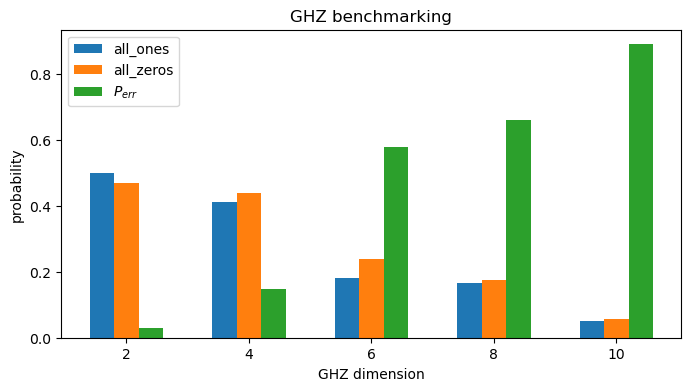

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_ion_q['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_ion_q['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_ion_q['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_ion_q['qubit_n'])
ax.set_title('GHZ benchmarking')
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

# Confronto con le simulazioni

In [57]:
local_simulator = DeviceUtils.get_device('dm1')

In [58]:
circuits =[Quil_to_Braket_Transpiler(scanner.get_compiled_circuit(),quil_rewiring=True).braket_circ for scanner in rigetti_task_scanners]
simulation_tasks = []
labels = []
qubit_mappings_sim = []
for i,n_qubits in enumerate(n_qubits_list):
    
    circ = circuits[i]
    noisy_circ,qubit_mapping = simulate_noise_aspen_m_2(circ)
    
    simulation_task = local_simulator.run(noisy_circ,shots=shots)
    
    simulation_tasks.append(simulation_task)
    qubit_mappings_sim.append(qubit_mapping)
    labels.append( "ls_rigetti_ghz_s1000_#q_" + str(n_qubits))

In [22]:
dump_tasks(simulation_tasks, labels, filename = "GHZ_l_s_.json")

In [59]:
ls_tasks = load_tasks("GHZ_l_s_.json")
ls_scanners = [BraketTaskScanner(qtask = task) for key, task in ls_tasks.items()]

status = [task.get_status() for task in ls_scanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [62]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

ls_results = [scanner.get_results() for scanner in ls_scanners]


for i,qubit_number in enumerate(n_qubits_list):
    results = ls_results[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    
measure_ls = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_ls

{'qubit_n': [2, 4, 6, 8, 10],
 'all_zeros': array([0.51 , 0.467, 0.419, 0.389, 0.126]),
 'all_ones': array([0.477, 0.455, 0.382, 0.323, 0.146]),
 'other': array([0.013, 0.078, 0.199, 0.288, 0.728])}

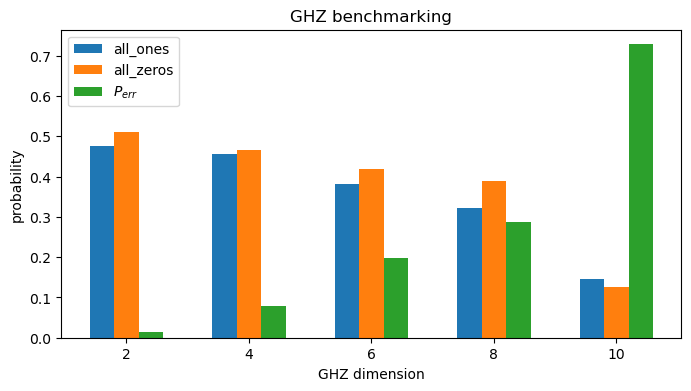

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_ls['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_ls['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_ls['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('GHZ benchmarking')
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

# Confronto con LS

In [3]:
rigetti_tasks = load_tasks("H_line_rigetti_grosso")
rigetti_scanners = [BraketTaskScanner(qtask = task) for key, task in rigetti_tasks.items()]
ls_tasks = load_tasks("H_line_l_s_grosso.json")
ls_scanners = [BraketTaskScanner(qtask = task) for key, task in ls_tasks.items()]


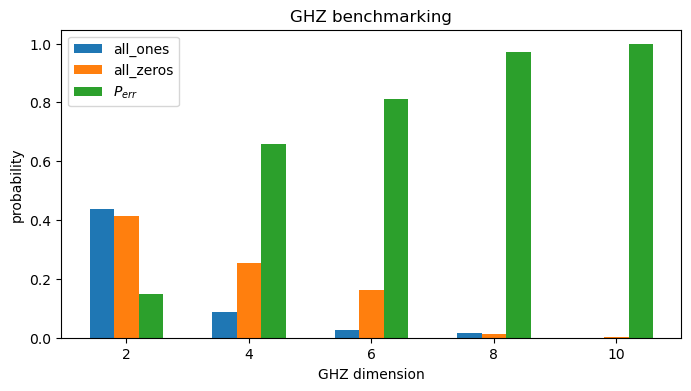

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_rigetti['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_rigetti['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_rigetti['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('GHZ benchmarking')
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

### testing that all Ionq physical gates Adjoint matrix

1. Gpi(theta)

In [24]:
theta = np.random.random()*2*np.pi
Circuit().gpi(0,theta).gpi(0,theta).as_unitary()

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

2. Gpi2(theta)

In [62]:
theta = np.random.random()*2*np.pi
Circuit().gpi2(0,theta).gpi2(0,np.pi+theta).as_unitary()

array([[ 1.00000000e+00+3.33066907e-16j,  2.22044605e-16-2.22044605e-16j],
       [-2.22044605e-16-2.22044605e-16j,  1.00000000e+00-3.33066907e-16j]])

3. Ms(t1,t2)

In [68]:
theta1,theta2 = np.random.random(2)*2*np.pi
Circuit().ms(0,1,theta1,theta2).ms(0,1,theta1,theta2+np.pi).as_unitary().round(3)

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.-0.j,  0.+0.j],
       [-0.+0.j,  0.+0.j,  0.+0.j,  1.-0.j]])

In [67]:
np.matrix(Circuit().ms(0,1,theta1,theta2).as_unitary()).H.round(3)

matrix([[ 0.707-0.j   ,  0.   -0.j   ,  0.   -0.j   , -0.652+0.273j],
        [ 0.   -0.j   ,  0.707-0.j   ,  0.681-0.19j ,  0.   -0.j   ],
        [ 0.   -0.j   , -0.681-0.19j ,  0.707-0.j   ,  0.   -0.j   ],
        [ 0.652+0.273j,  0.   -0.j   ,  0.   -0.j   ,  0.707-0.j   ]])